# SYDE 556/750 --- Assignment 1
**Student ID: 20854840**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_01/syde556_assignment_01.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci # For question 2.1b)

from matplotlib import cm


# Fix the numpy random seed for reproducible results
#np.random.seed(18945)
np.random.seed(20854840)
# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Representation of Scalars

## 1.1 Basic encoding and decoding

**a) Computing gain and bias.** In general, for a neuron model $a = G[J]$ (and assuming that the inverse $J = G^{-1}[a]$ exists), solve the following system of equations to compute the gain $\alpha$, and the bias $J^\mathrm{bias}$ given a maximum rate $a^\mathrm{max}$ and an $x$-intercept $\xi$.

$$a^\mathrm{max} = G[\alpha + J^\mathrm{bias}] \,, \quad\quad 0 = G[\alpha \xi + J^\mathrm{bias}] \,.$$

We know that

$$a^\mathrm{max}=G[\alpha + J^\mathrm{bias}]$$

$$ \tag{1} => G^\mathrm{-1}[a^\mathrm{max}] = \alpha + J^{bias} $$

We also know that

$$ 0=G[\alpha \xi + J^\mathrm{bias}]    $$

Taking G to the other side as $G^\mathrm{-1}$ (and also knowing that $G^\mathrm{-1}[0] = J^{th}$ and adding the encoder ($e$) into the equation)

$$ => G^\mathrm{-1}[0]=\alpha \xi+J^\mathrm{bias} $$

$$ => J^{th}=\alpha \xi+J^\mathrm{bias} $$

Isolating for $J^\mathrm{bias}$ , this leads to giving us equation 2

$$\tag{2} J^\mathrm{bias} =J^{th}-\alpha \xi  $$

Substituting equation 2 into equation 1, we obtain
$$G^\mathrm{-1}[a^\mathrm{max}]=\alpha+J^{th}-\alpha \xi$$

$$ \alpha -  \alpha \xi=G^\mathrm{-1}[a^\mathrm{max}]-J^{th} $$

$$ \alpha (1-  \xi)=G^\mathrm{-1}[a^\mathrm{max}]-J^{th} $$
$$\tag{3} \alpha = \frac{G^\mathrm{-1}[a^\mathrm{max}]-J^{th}}{(1-  \xi)} $$

Subbing the equation back into equation (2)

$$J^\mathrm{bias} =J^{th}-\frac{G^\mathrm{-1}[a^\mathrm{max}]-J^{th}}{(1-  \xi)} \xi$$

$$\tag{4}=> J^\mathrm{bias} = \frac{J^{th}(1-\xi)-G^{-1}[a^{max}]\xi+J^{th}\xi}{(1-\xi)} = \frac{J^{th}-J^{th}\xi-G^{-1}[a^{max}]e\xi-J^{th}\xi}{(1-\xi)} = \frac{J^{th}-G^{-1}[a^{max}]\xi}{(1-\xi)} 

Now, simplify these equations for the specific case $G[J] = \max(J, 0)$.

Now when $G[J]=max(J,0)$ (being the linear rate approx of a neuron), then we know that for

$$ J>J^{th} $$

then,

$$G[J] = J$$

otherwise it would be 0. Using this fact, we can further simplify the given equations

$$a^\mathrm{max} = G[\alpha + J^\mathrm{bias}] \,, \quad\quad 0 = G[\alpha \xi + J^\mathrm{bias}] \,.$$

into

$$a^{max}=\alpha+J^{bias} \,, 0=\alpha\xi+J^{bias}  $$


$$=> J^{bias} = -\alpha e \xi (e -> encoder) $$

subbing it into the $a^{max}$ equation, we get

$$ a^{max} = \alpha - \alpha\xi = \alpha (1-\xi) $$

$$ \tag{5}\alpha = \frac{a^{max}}{(1-\xi)}  $$


Subbing equation (5) back into the $a^{max}$ equation

$$ a^{max} =  \frac{a^{max}}{(1-\xi)}+J^{bias}   $$


$$ a^{max}-a^{max}\xi =  a^{max}+J^{bias}(1-\xi)   $$



$$ \tag{6} J^{bias} = \frac{-a^{max}\xi}{(1-\xi)} =- \alpha e \xi $$




**b) Neuron tuning curves.** Plot the neuron tuning curves $a_i(x)$ for 16 randomly generated neurons following the intercept and maximum rate distributions described above.

In [2]:
# Establish number of neurons

numNeurons = 16

tauRef = 0.002
tauRC = 0.020

# Generate max firing rate that is uniformly distributed with given freqs

lowFreq = 100
highFreq = 200
numSamplesaMax = numNeurons # Getting the number of neurons as samples
setaMax= np.random.uniform(lowFreq, highFreq, numSamplesaMax)


# print(setaMax) --> ignore this is me testing some kernels stuff


# generate random intercepts (x intercepts b/w given limits)

minIntercept = -0.95
maxIntercept = 0.95
numSamplesintercepts = numNeurons
setIntercept = np.random.uniform(minIntercept, maxIntercept, numSamplesintercepts)

# print(setIntercept) --> ignore this is me testing some kernels stuff



`Gain, Bias, and encoder Helper (might get used in subsequent questions)

In [3]:
def gain(aMax, xIntercept, e):
    
    return aMax / abs(e - xIntercept)

def bias(xIntercept, e, gain):
   
    return -(gain) * xIntercept * e


def reluEncode(neuron, x):
        rate = max(neuron.a * x * neuron.encoderLimit + neuron.jBias, 0)
        return rate

def RMSE(x, y):
    return np.sqrt(np.mean(np.power(x - y, 2)))

    


Create the Rectified linear neuron

In [4]:
class ReluNeuron:
    def __init__(self, aMax, xIntercept, id):
        self.id = id
        self.aMax = aMax
        
        self.rate = []
        self.encoderLimit = np.random.choice([-1,1])

        a = gain(aMax, xIntercept, self.encoderLimit)
        self.a = a
        jBias = bias(xIntercept, self.encoderLimit, a)
        self.jBias = jBias

    def rateRelu(self, x):
        return reluEncode(self,x)

    def findRate(self, space):
        for element in space:
            self.rate.append(self.rateRelu(element))

# Create neurons
reluNeurons = []
for i in range(numNeurons):
   reluNeurons.append(ReluNeuron(setaMax[i], setIntercept[i], i))

x = np.linspace(-1,1,41) # Sampled with 41 monotonously increasing x values

for neuron in reluNeurons:
    neuron.findRate(x)

Now for the fun stuff, PLOTTING!!

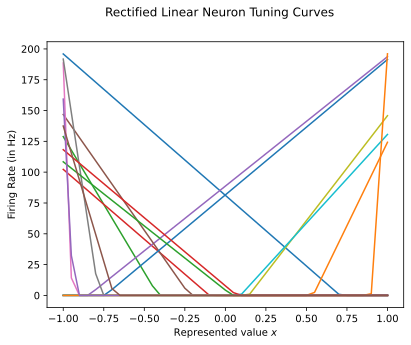

In [5]:
plt.figure()
plt.suptitle("Rectified Linear Neuron Tuning Curves")
for neuron in reluNeurons:
    plt.plot(x, neuron.rate)
plt.xlabel("Represented value $x$")
plt.ylabel("Firing Rate (in Hz)")
plt.show()

**c) Computing identity decoders.** Compute the optimal identity decoder $\vec d$ for those 16 neurons (as shown in class). Report the value of the individual decoder coefficients. Compute $d$ using the matrix notation mentioned in the course notes. Do not apply any regularization. $A$ is the matrix of activities (the same data used to generate the plot in 1.1b).

Make an array of activities and inputs and then append the neuron rates and x values. Once that is done, you can use the following equation

$$ {D^T}\approx(\bold{A}{A^T})^{-1}{A}{X^T} $$

<img src="image.png" align="centre"/>

In [6]:
activities = []
input = []

for neuron in reluNeurons:
    activities.append(neuron.rate)
    input.append(x)

A = np.array(activities)
X = np.array(input)

# Dot product of equation shown (also from notes ^_^)
d = np.linalg.lstsq(A.T, X.T, rcond=None)[0].T[0]

print("---------------------------------------------------------------------------------------------------------")
print("Decoded values =")
print(d)
print("---------------------------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------------------------
Decoded values =
[-3.08960832e-05  8.60829832e-06 -2.08476210e-06 -4.03293662e-04
  3.60780367e-04  5.70790935e-05  2.09928056e-05 -8.91644798e-05
 -1.53063537e-04  6.35049745e-03  6.35518626e-04  1.71611953e-06
  7.84402176e-03 -1.51140399e-02 -3.37522838e-05 -4.11912902e-05]
---------------------------------------------------------------------------------------------------------


**d) Evaluating decoding errors.** Compute and plot $\hat{x}=\sum_i d_i a_i(x)$. Overlay on the plot the line $y=x$. Make a separate plot of $x-\hat{x}$ to see what the error looks like. Report the Root Mean Squared Error (RMSE) value.

Plot for decoded values xHat and expected values x

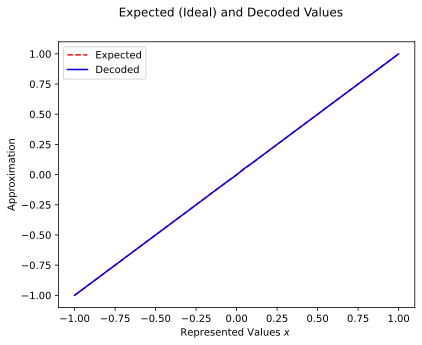

In [7]:
xHat = np.dot(d,A)

plt.figure()

plt.suptitle("Expected (Ideal) and Decoded Values")
plt.plot(x, x, 'r', label='Expected', linestyle="dashed")
plt.plot(x, xHat, "b", label='Decoded')
plt.xlabel("Represented Values $x$ ")
plt.ylabel("Approximation")
plt.legend()

Decoded values seem to be aligned with the expected model

Plotting error $e = x - \hat x$

Text(0, 0.5, 'Error ($x$ - $\\hat x$)')

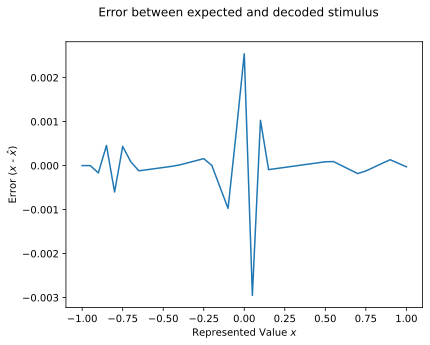

In [8]:
# Calculate error which is the diff b/w x and xHat

error = x - xHat # Error b/w x and xHat

plt.figure()
plt.suptitle("Error between expected and decoded stimulus")
plt.plot(x, error)
plt.xlabel("Represented Value $x$")
plt.ylabel("Error ($x$ - $\hat x$)")


Calculate the root mean squared error (RMSE)

In [9]:
xRMSE = RMSE(x, xHat)
xRMSE_rounded = np.round(xRMSE, 5)
print("---------------------------------------------")
print("Root Mean Squared Error =", xRMSE_rounded)
print("---------------------------------------------")

---------------------------------------------
Root Mean Squared Error = 0.00068
---------------------------------------------


**e) Decoding under noise.** Now try decoding under noise. Add random normally distributed noise to $a$ and decode again. The noise is a random variable with mean $\mu=0$ and standard deviation of $\sigma=0.2 \max(A)$ (where $\max(A)$ is the maximum firing rate of all the neurons). Resample this variable for every different $x$ value for every different neuron. Create all the same plots as in part d). Report the RMSE.


Creating values for $\hat x_{noise}$ and plotting them out similar to what we did in part d)

---------------------------------------------
Root Mean Squared Error = 0.82723
---------------------------------------------


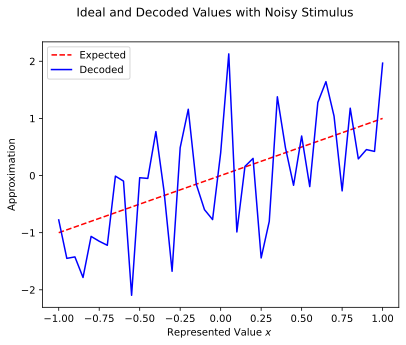

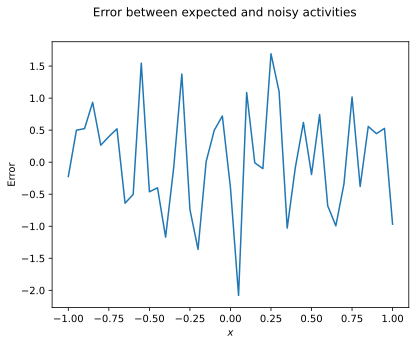

In [10]:
meanNoise = 0
stdDevnoise = 0.2 * np.max(A)

eNoise = np.random.normal(scale=stdDevnoise, size=np.shape(A))
aNoise = A + eNoise


xHatnoise = np.dot(d, aNoise)

# print(xHatnoise)

plt.figure()

plt.suptitle("Ideal and Decoded Values with Noisy Stimulus")
plt.plot(x, x, 'r', linestyle = "dashed", label='Expected')
plt.plot(x, xHatnoise, "b", label='Decoded')
plt.xlabel("Represented Value $x$ ")
plt.ylabel("Approximation")
plt.legend()

errorNoise = x - xHatnoise
plt.figure()
plt.suptitle("Error between expected and noisy activities")
plt.plot(x, errorNoise)
plt.xlabel("$x$")
plt.ylabel("Error")


xRMSEnoise = RMSE(x, xHatnoise)
xRMSEnoise_rounded = np.round(xRMSEnoise, 5)
print("---------------------------------------------")
print("Root Mean Squared Error =", xRMSEnoise_rounded)
print("---------------------------------------------")


**f) Accounting for decoder noise.** Recompute the decoder $\vec d$ taking noise into account (i.e., apply the appropriate regularization, as shown in class). Show how these decoders behave when decoding both with and without noise added to $a$ by making the same plots as in d) and e). Report the RMSE for all cases.

We know from class that the decoder d, added with some noise into account, can be found by the following equation:


$$ d_{noisy} \approx (\bold{A}\bold{A^{T}}+N\sigma^{2}\bold{I})^{-1}\bold{A}\bold{X^{T}} $$

In [11]:
# If we account for the decoder noise
N = numNeurons
n = len(A)


dWithnoise = np.linalg.lstsq(
    A @ A.T +  N * np.square(stdDevnoise)* np.eye(n),
    A @ X.T,
    rcond= None
)[0].T[0]

print("---------------------------------------------------------------------------------------------------------")
print("Decoded values =")
print(dWithnoise)
print("---------------------------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------------------------
Decoded values =
[-2.50620299e-03  5.94295922e-04 -3.38700107e-04 -7.06138639e-04
  1.32537317e-03 -7.48207217e-04 -2.43600219e-05 -1.04236643e-04
  1.25416320e-03  1.18495300e-03  1.44890606e-03  2.10354964e-04
 -9.74572587e-04 -1.11050160e-03 -2.67854669e-05 -1.08393209e-04]
---------------------------------------------------------------------------------------------------------


Now plotting these decoded values of $\hat x$ and the expected/true input $x$ using noisy decoders $d_{noisy}$

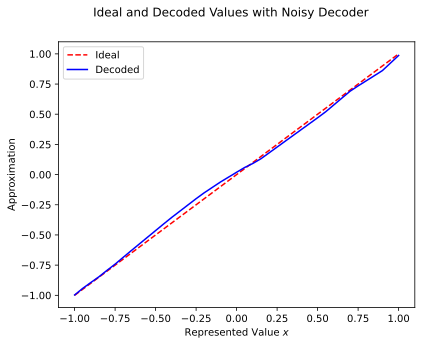

In [12]:
xHatnoisyDecoder = np.dot(dWithnoise, A)

plt.suptitle("Ideal and Decoded Values with Noisy Decoder")
plt.plot(x,x,"r", label="Ideal", linestyle="dashed")
plt.plot(x,xHatnoisyDecoder, "b", label="Decoded")
plt.xlabel("Represented Value $x$")
plt.ylabel("Approximation")
plt.legend()

Next up, plotting the difference/error b/w $x$ and $\hat x$

i.e,

$$ e=x-\hat x $$

Text(0, 0.5, 'Error (x-$\\hat x$)')

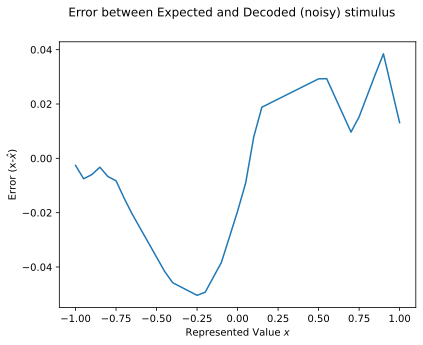

In [13]:
errorNoisedecoder = x-xHatnoisyDecoder

plt.suptitle("Error between Expected and Decoded (noisy) stimulus")
plt.plot(x, errorNoisedecoder)
plt.xlabel("Represented Value $x$")
plt.ylabel("Error (x-$\hat x$)")


Reporting out on RMSE of noisy decoder

In [14]:
xRMSEnoisydecoder = RMSE(x, xHatnoisyDecoder)
xRMSEnoisydecoder_rounded = np.round(xRMSEnoisydecoder, 5)
print("---------------------------------------------")
print("Root Mean Squared Error =", xRMSEnoisydecoder_rounded)
print("---------------------------------------------")

---------------------------------------------
Root Mean Squared Error = 0.02815
---------------------------------------------


Next, we plot of $\hat x$ and the expected values of $x$ using the decoders computed with noise and the activities computed with noise ($d_{noise}$ and $A_{noise}$ respectively)

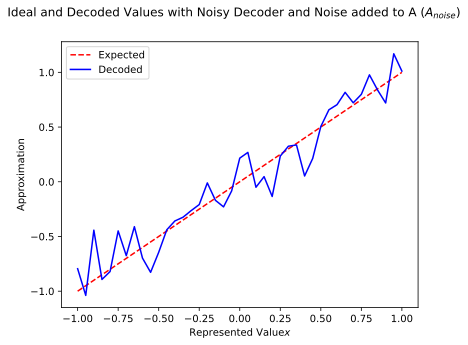

In [15]:
xHatnoisydecoder_noisyA = np.dot(dWithnoise, aNoise)
plt.suptitle("Ideal and Decoded Values with Noisy Decoder and Noise added to A ($A_{noise}$)")
plt.plot(x,x,"r", linestyle="dashed", label="Expected")
plt.plot(x,xHatnoisydecoder_noisyA, "b", label="Decoded")
plt.xlabel("Represented Value$x$")
plt.ylabel("Approximation")
plt.legend()


Now the error from the above noisy $\hat x$

Text(0, 0.5, 'Error (x-$\\hat x$)')

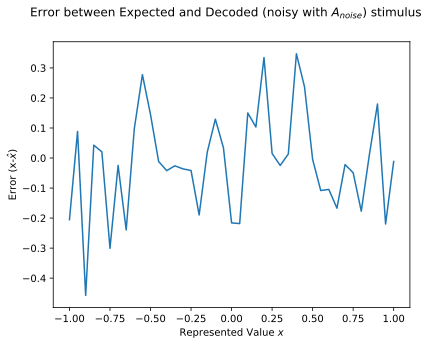

In [16]:
errorNoisydecodernoisyA = x - xHatnoisydecoder_noisyA
plt.suptitle("Error between Expected and Decoded (noisy with $A_{noise}$) stimulus")
plt.plot(x, errorNoisydecodernoisyA)
plt.xlabel("Represented Value $x$")
plt.ylabel("Error (x-$\hat x$)")

Finally, reporting out on the RMSE

In [17]:
xRMSEnoisenoisyA = RMSE(x,xHatnoisydecoder_noisyA)
xRMSEnoisenoisyA_rounded = np.round(xRMSEnoisenoisyA, 5)
print("---------------------------------------------")
print("Root Mean Squared Error =", xRMSEnoisenoisyA_rounded)
print("---------------------------------------------")

---------------------------------------------
Root Mean Squared Error = 0.16819
---------------------------------------------


**g) Interpretation.** Show a 2x2 table of the four RMSE values reported in parts d), e), and f). This should show the effects of adding noise and whether the decoders $d$ are computed taking noise into account. Write a few sentences commenting on what the table shows, i.e., what the effect of adding noise to the activities is with respect to the measured error and why accounting for noise when computing the decoders increases/decreases/does not change the measured RMSE.

|                | Simple (Non-Regularized) Decoder | Noise Optimized (Regularized) Decoder |
| ---------------| ---------------- | ----------------------- |
| No Noise Present| 0.00068         | 0.02815
| Gaussian Noise added| 0.82723     | 0.16819

By inspection of the above table, we can see that if we add noise to the activies in the Simple Decoder's case, we see a $10^{3} $ increase in the RMSE values. If we see the noise optimized decoder , the RMSE values increased by a factor of $10$

When we examine the performance of both the simple and noise-tuned decoders in scenarios with and without Gaussian noise, a noteworthy observation emerges: the RMSE values in the presence of Gaussian noise decrease when utilizing the noise-tuned decoder, as compared to scenarios without noise. This phenomenon resembles a double-edged sword, wherein tuning the decoder to account for noise yields a "better" outcome in adverse conditions but leads to a "worse" outcome in favorable conditions.

## 1.2 Exploring sources of error

**a) Exploring error due to distortion and noise.** Plot the error due to distortion $E_\mathrm{dist}$ and the error due to noise $E_\mathrm{noise}$ as a function of $n$, the number of neurons. Generate two different loglog plots (one for each type of error) with $n$ values of at least $[4, 8, 16, 32, 64, 128, 256, 512]$. For each $n$ value, do at least $5$ runs and average the results. For each run, different $\alpha$, $J^\mathrm{bias}$, and $e$ values should be generated for each neuron. Compute $d$ taking noise into account, with $\sigma = 0.1 \max(A)$. Show visually that the errors are proportional to $1/n$ or $1/n^2$.

In [18]:
neuronsToEval = [4,8,16,32,64,128,200,256,300,400,512]
numRuns = 5
deltaN = 41
stdDevVal = 0.1
n = [1/N for N in neuronsToEval]
n2 = [1/np.power(N,2) for N in neuronsToEval]

# Creating helper function to calculate error given the number runs, stdDev 
# and neurons to evaluate in the given set
num_neurons_to_eval = [4, 8, 16, 32, 64, 128, 256, 512]
num_runs = 5


def findError(stddev_factor, runs, neuronsToEval):
    E_dist = []
    E_noise = []
    for amount_of_neurons in neuronsToEval:
        e_dist = []
        e_noise = []
        for r in range(runs):
            local_neurons = []
            for i in range(amount_of_neurons):
                local_neurons.append(
                    ReluNeuron(
                        np.random.uniform(lowFreq, highFreq),
                        np.random.uniform(minIntercept, maxIntercept),
                        i,
                    )
                )
            local_activies = []
            local_inputs = []
            for neuron in local_neurons:
                neuron.findRate(x)
            for neuron in local_neurons:
                local_activies.append(neuron.rate)
                local_inputs.append(x)
           
            A_L = np.array(local_activies) # make activities matrix
            X_L = np.array(local_inputs) # make inputs matrix
            sigmaNoise = stddev_factor * np.amax(A_L)
            N_L = len(x)
            n_L = len(local_neurons)
            dLocalNoisy = np.linalg.lstsq(
                A_L @ A_L.T + N_L * np.square(sigmaNoise) * np.eye(n_L),
                A_L @ X_L.T,
                rcond=None,
            )[0].T[0]
            local_x_hat = np.dot(dLocalNoisy, A_L)
            e_dist_L = 0.5 * sum(np.power(x-(local_x_hat), 2)) * 0.05
            e_noise_L = 0.5 * np.square(sigmaNoise) * sum(np.power(dLocalNoisy,2))
            e_dist.append(e_dist_L)
            e_noise.append(e_noise_L)

        E_dist.append(np.mean(e_dist))
        E_noise.append(np.mean(e_noise))

    return E_dist, E_noise
    



Using the above helper function, the values of $E_{noise}$ and $E_{dist}$ can be calculated

In [19]:
error_Dist, error_Noise = findError(stdDevVal, numRuns, neuronsToEval)

Plotting the $E_{noise}$ out

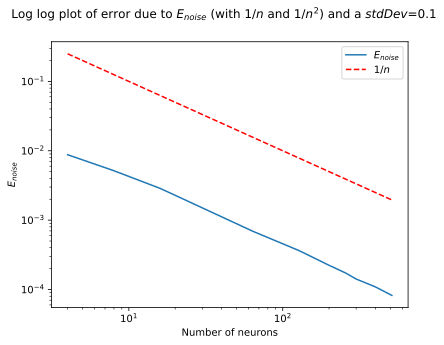

In [20]:
plt.suptitle("Log log plot of error due to $E_{noise}$ (with $1/n$ and $1/n^{2}$) and a $stdDev$=0.1")
#plt.plot(numNeuronsToEval, error_Noise, label="$E_{noise}$")
#plt.plot(numNeuronsToEval, n, "r", linestyle="dashed", label="$1/n$")
#plt.plot(numNeuronsToEval, n2, "g", linestyle="dashed", label="$1/n^{2}$")
plt.loglog(neuronsToEval, error_Noise, label="$E_{noise}$")
plt.loglog(neuronsToEval, n, "r", linestyle="dashed", label="$1/n$")


plt.xlabel("Number of neurons")
plt.ylabel("$E_{noise}$")
plt.legend()
plt.show()


PLotting $E_{dist}$

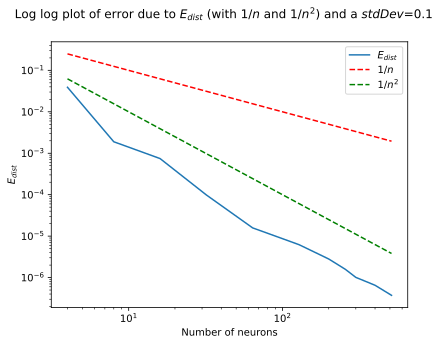

In [21]:
plt.suptitle("Log log plot of error due to $E_{dist}$ (with $1/n$ and $1/n^{2}$) and a $stdDev$=0.1")
plt.loglog(neuronsToEval, error_Dist, label="$E_{dist}$")
plt.loglog(neuronsToEval, n, "r", linestyle="dashed", label="$1/n$")
plt.loglog(neuronsToEval, n2, "g", linestyle="dashed", label="$1/n^{2}$")

plt.xlabel("Number of neurons")
plt.ylabel("$E_{dist}$")
plt.legend()
plt.show()



**b) Adapting the noise level.** Repeat part a) with $\sigma = 0.01 \max(A)$.

Adding $\sigma = 0.01 \max(A)$ and replotting the graphs

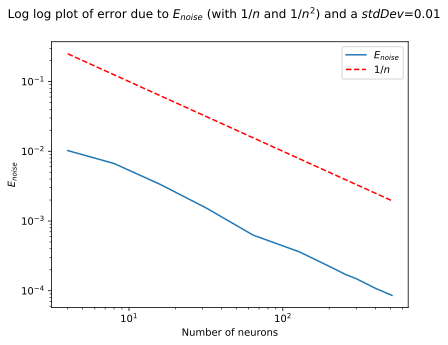

In [22]:
stdDevVal_2 = 0.1

error_Dist, error_Noise = findError(stdDevVal_2, numRuns, neuronsToEval)

plt.suptitle("Log log plot of error due to $E_{noise}$ (with $1/n$ and $1/n^{2}$) and a $stdDev$=0.01")
plt.loglog(neuronsToEval, error_Noise, label="$E_{noise}$")
plt.loglog(neuronsToEval, n, "r", linestyle="dashed", label="$1/n$")

plt.xlabel("Number of neurons")
plt.ylabel("$E_{noise}$")
plt.legend()
plt.show()

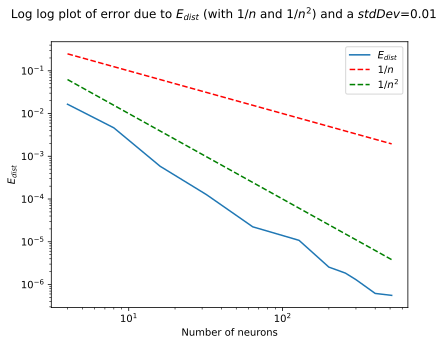

In [23]:
plt.suptitle("Log log plot of error due to $E_{dist}$ (with $1/n$ and $1/n^{2}$) and a $stdDev$=0.01")
plt.loglog(neuronsToEval, error_Dist, label="$E_{dist}$")
plt.loglog(neuronsToEval, n, "r", linestyle="dashed", label="$1/n$")
plt.loglog(neuronsToEval, n2, "g", linestyle="dashed", label="$1/n^{2}$")

plt.xlabel("Number of neurons")
plt.ylabel("$E_{dist}$")
plt.legend()
plt.show()


**c) Interpretation.** What does the difference between the graphs in a) and b) tell us about the sources of error in neural populations?

✍ \<YOUR SOLUTION HERE\>

## 1.3 Leaky Integrate-and-Fire neurons

**a) Computing gain and bias.** As in the second part of 1.1a), given a maximum firing rate $a^\mathrm{max}$ and a bias $J^\mathrm{bias}$, write down the equations for computing $\alpha$ and the $J^\mathrm{bias}$ for this specific neuron model.

It is given that 

$$\tag{1} G[J]=\frac{1}{\tau_{ref}-\tau_{RC}{ln(1-\frac{1}{J})}}, J>1 $$

and 
$$\tag{2} G[J]=0, otherwise $$

Using these two equations, we can further simplify the equations below
$$a^\mathrm{max} = G[\alpha + J^\mathrm{bias}] ; \quad\quad 0 = G[\alpha \xi + J^\mathrm{bias}] \,.$$

which will then turn into

$$ a^\mathrm{max}=\frac{1}{\tau_{ref}-\tau_{RC}{\ln{\left(1-\frac{1}{\alpha + J^\mathrm{bias}}\right)}}} ; \quad\quad 0 =\alpha \xi + J^\mathrm{bias} $$

If we were to rearrange for $\frac{1}{\alpha+J^\mathrm{bias}}$ in the first equation and moving $J^\mathrm{bias}$ to the left in the second equation $$\tag{3} \frac{1}{\alpha+J^\mathrm{bias}}=1-e^{\frac{\tau_{ref-\frac{1}{a^\mathrm{max}}}}{\tau_{RC}}}$$
$$ \tag {4}  J^\mathrm{bias}=-\alpha \xi $$


Subbing equation (4) into (3) we get

$$\frac{1}{\alpha-\alpha\epsilon} = 1-e^{\frac{\tau_{ref}-\frac{1}{a^{max}}}{\tau_{RC}}}$$
$$=> \frac{1}{\alpha(1-\epsilon)} = 1-e^{\frac{\tau_{ref}-\frac{1}{a^{max}}}{\tau_{RC}}}$$

Isolating for $\alpha$ we get

$$\tag{5} \alpha = \frac{1}{(1-\epsilon)1-e^{\frac{\tau_{ref}-\frac{1}{a^{max}}}{\tau_{RC}}}} $$


We can now use equations (4) and (5) to get our gains and Jbias' to simulate LIF neurons

**b) Neuron tuning curves.** Generate the same plot as in 1.1b). Use $\tau_\mathrm{ref}=2 \mathrm{ms}$ and $\tau_{RC}=20 \mathrm{ms}$. Use the same distribution of $x$-intercepts and maximum firing rates as in 1.1.

Create helper funcs, similar to the relu helper functions

In [24]:
import numpy as np

def biasLIF(xIntercept, e, gainLIF):
    return -(gainLIF) * xIntercept * e

def lifEncode(neuron, x, tauRef, tauRC):
    J = neuron.a * x * neuron.encoderLimit + neuron.jBias
    if J > 1:
        return 1 / (tauRef - tauRC * np.log(1 - (1 / J)))
    return 0

def gainLIF(aMax, xIntercept, e, tauRef, tauRC):
    encode = abs(e - xIntercept)
    exponentTerm = 1 - np.exp((tauRef - 1 / aMax) / tauRC)
    return 1 / (encode * exponentTerm)

class LIFNeuron:
    def __init__(self, aMax, xIntercept, id, tauRef, tauRC):
        self.id = id
        self.aMax = aMax
        self.rate = []
        self.encoderLimit = np.random.choice([-1, 1])

        a = gainLIF(aMax, xIntercept, self.encoderLimit, tauRef, tauRC)
        self.a = a
        jBias = biasLIF(xIntercept, self.encoderLimit, a)
        self.jBias = jBias

    def rateLIF(self, x, tauRef, tauRC):
        return lifEncode(self, x, tauRef, tauRC)

    def findRateLIF(self, space, tauRef, tauRC):
        for element in space:
            self.rate.append(self.rateLIF(element, tauRef, tauRC))

# Define parameters
numNeurons = 16
setaMax = np.random.uniform(100, 200, numNeurons)
setIntercept = np.random.uniform(-0.95, 0.95, numNeurons)
tauRef = 0.002  # Set your desired tauRef value
tauRC = 0.02   # Set your desired tauRC value

lifNeurons = []

# Create LIFNeuron instances
for i in range(numNeurons):
    lifNeurons.append(LIFNeuron(setaMax[i], setIntercept[i], i, tauRef, tauRC))

x = np.linspace(-1, 1, 41)

# Calculate rates for LIFNeurons
for neuron in lifNeurons:
    neuron.findRateLIF(x, tauRef, tauRC)


Plotting values similar to question 1.1b)

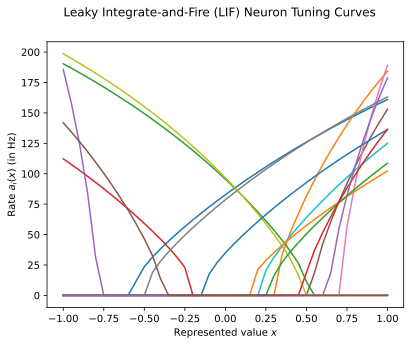

In [25]:
plt.suptitle("Leaky Integrate-and-Fire (LIF) Neuron Tuning Curves")
for neuron in lifNeurons:
    plt.plot(x, neuron.rate)
plt.xlabel("Represented value $x$")
plt.ylabel("Rate $a_i(x)$ (in Hz)")
plt.show()

**c) Impact of noise.** Generate the same four plots as in 1.1f) (adding/not adding noise to $A$, accounting/not accounting for noise when computing $\vec d$), and report the RMSE both with and without noise.

In [26]:
lifActivities = []
lifInputs = []

for neuron in lifNeurons:
    lifActivities.append(neuron.rate)
    lifInputs.append(x)

aLIF = np.array(lifActivities)
xLIF = np.array(lifInputs)
stdDevLIF = 0.2*np.amax(aLIF)
eNoiseLIF = np.random.normal(stdDevLIF, size=np.shape(aLIF))
aNoiseLIF = aLIF + eNoiseLIF

nLIF = numNeurons
NLIF = len(x)
dNoiseLIF = np.linalg.lstsq(
    aLIF @ aLIF.T + NLIF * np.square(stdDevLIF) * np.eye(nLIF),
    aLIF @ xLIF.T,
    rcond=None
)[0].T[0]

# Decoder with no noise
dLIF = np.linalg.lstsq(aLIF.T, xLIF.T, rcond=None)[0].T[0]

print("---------------------------------------------------------------------------------------------------------")
print("Decoders for Noisy LIF =")
print(dNoiseLIF)
print("---------------------------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------------------------
Decoders for Noisy LIF =
[ 0.00123425  0.00052265 -0.00131839 -0.00095436 -0.00068963  0.00031305
  0.00030341  0.0012409  -0.00141841  0.0004467   0.00089018  0.00043209
  0.00033746  0.00028964  0.00032273 -0.00105404]
---------------------------------------------------------------------------------------------------------


Text(0, 0.5, 'Approximation')

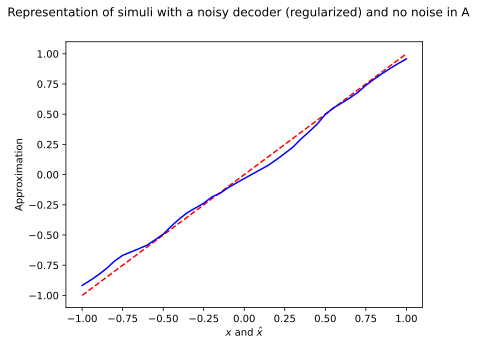

In [27]:
xHatNoisyDecoderLIF = np.dot(dNoiseLIF, aLIF)
plt.suptitle("Representation of simuli with a noisy decoder (regularized) and no noise in A")
plt.plot(x,x,"r", linestyle="dashed", label="Expected")
plt.plot(x,xHatNoisyDecoderLIF, "b", label="Regularized Noisy Decoder")
plt.xlabel("$x$ and $\hat x $")
plt.ylabel("Approximation")

Next, need to plot the error between $x$ and $\hat x$ for the LIF neurons

Text(0, 0.5, 'Error')

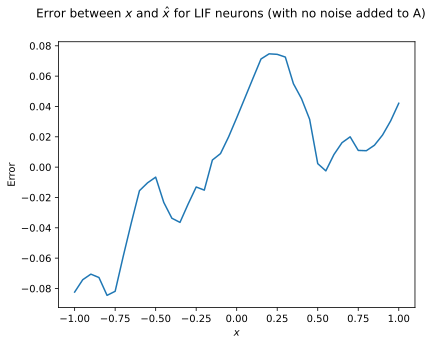

In [28]:
errorDecoderLIF = x-xHatNoisyDecoderLIF
plt.suptitle("Error between $x$ and $\hat x$ for LIF neurons (with no noise added to A)")
plt.plot(x,errorDecoderLIF)
plt.xlabel("$x$")
plt.ylabel("Error")



Reporting the RMSE values for the noisy decoder used on the LIF neurons

In [29]:
RMSENoisyDecoderLIF = RMSE(x,xHatNoisyDecoderLIF)
RMSENoisyDecoderLIF_rounded = np.round(RMSENoisyDecoderLIF, 5)
print("---------------------------------------------")
print("Root Mean Squared Error =", RMSENoisyDecoderLIF_rounded)
print("---------------------------------------------")

---------------------------------------------
Root Mean Squared Error = 0.0454
---------------------------------------------


Repeating all the steps for noisy $A$

Text(0, 0.5, 'Approximation')

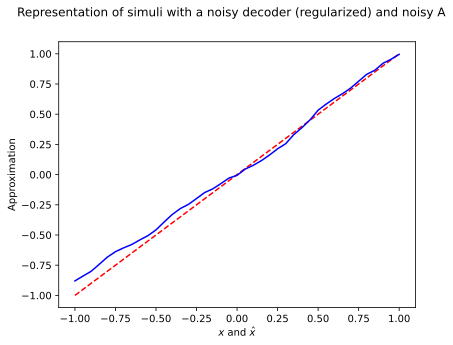

In [30]:
xHatNoisyDecoderLIF_noisyA = np.dot(dNoiseLIF, aNoiseLIF)
plt.suptitle("Representation of simuli with a noisy decoder (regularized) and noisy A")
plt.plot(x,x,"r", linestyle="dashed", label="Expected")
plt.plot(x,xHatNoisyDecoderLIF_noisyA, "b", label="Regularized Noisy Decoder with Noisy A")
plt.xlabel("$x$ and $\hat x $")
plt.ylabel("Approximation")



Text(0, 0.5, 'Error')

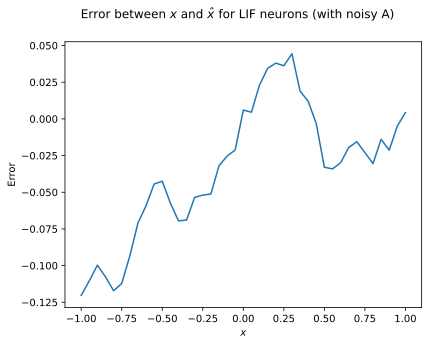

In [31]:
errorDecoderLIF_noisyA = x-xHatNoisyDecoderLIF_noisyA
plt.suptitle("Error between $x$ and $\hat x$ for LIF neurons (with noisy A)")
plt.plot(x,errorDecoderLIF_noisyA)
plt.xlabel("$x$")
plt.ylabel("Error")

In [32]:
RMSENoisyDecoderLIF_noisyA = RMSE(x,xHatNoisyDecoderLIF_noisyA)
RMSENoisyDecoderLIF_noisyA_rounded = np.round(RMSENoisyDecoderLIF_noisyA, 5)
print("---------------------------------------------")
print("Root Mean Squared Error =", RMSENoisyDecoderLIF_noisyA_rounded)
print("---------------------------------------------")

---------------------------------------------
Root Mean Squared Error = 0.05667
---------------------------------------------


Text(0, 0.5, 'Approximation')

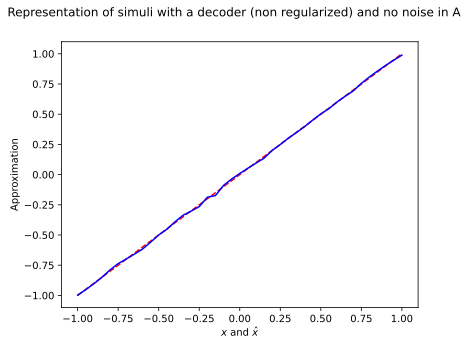

In [33]:
xHatLIF = np.dot(dLIF, aLIF)
plt.suptitle("Representation of simuli with a decoder (non regularized) and no noise in A")
plt.plot(x,x,"r", linestyle="dashed", label="Expected")
plt.plot(x,xHatLIF, "b", label="Regularized Noisy Decoder")
plt.xlabel("$x$ and $\hat x $")
plt.ylabel("Approximation")

Text(0, 0.5, 'Error')

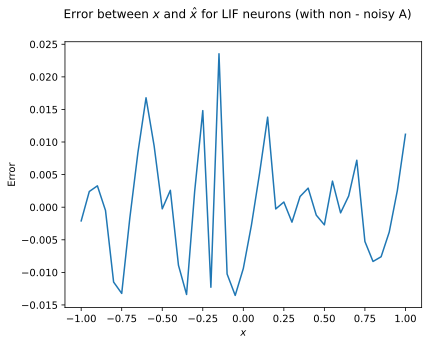

In [34]:
# Calculating error between x and xHatLIF
errorDecLIF = x-xHatLIF
plt.suptitle("Error between $x$ and $\hat x$ for LIF neurons (with non - noisy A)")
plt.plot(x,errorDecLIF)
plt.xlabel("$x$")
plt.ylabel("Error")

Computing RMSE values for Non regularized Decoder and no noise added to A

In [35]:
RMSELIF= RMSE(x,xHatLIF)
RMSELIF_rounded = np.round(RMSELIF, 5)
print("---------------------------------------------")
print("Root Mean Squared Error =", RMSELIF_rounded)
print("---------------------------------------------")

---------------------------------------------
Root Mean Squared Error = 0.00851
---------------------------------------------


Text(0, 0.5, 'Approximation')

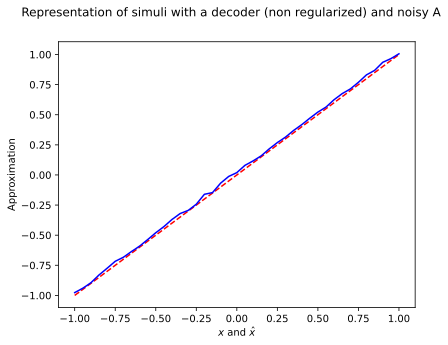

In [36]:
xHatLIF_noisyA = np.dot(dLIF, aNoiseLIF)
plt.suptitle("Representation of simuli with a decoder (non regularized) and noisy A")
plt.plot(x,x,"r", linestyle="dashed", label="Expected")
plt.plot(x,xHatLIF_noisyA, "b", label="Regularized Noisy Decoder")
plt.xlabel("$x$ and $\hat x $")
plt.ylabel("Approximation")

Text(0, 0.5, 'Error')

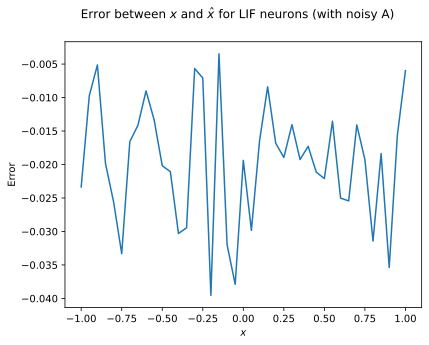

In [37]:
# Calculating error between x and xHatLIF
errorDecLIF_noisyA = x-xHatLIF_noisyA
plt.suptitle("Error between $x$ and $\hat x$ for LIF neurons (with noisy A)")
plt.plot(x,errorDecLIF_noisyA)
plt.xlabel("$x$")
plt.ylabel("Error")

Calculating RMSE Values

In [38]:
RMSELIF_noisyA= RMSE(x,xHatLIF_noisyA)
RMSELIF_rounded = np.round(RMSELIF_noisyA, 5)
print("---------------------------------------------")
print("Root Mean Squared Error =", RMSELIF_rounded)
print("---------------------------------------------")

---------------------------------------------
Root Mean Squared Error = 0.02167
---------------------------------------------


# 2. Reperesentation of Vectors

## 2.1 Vector tuning curves

**a) Plotting 2D tuning curves.** Plot the tuning curve of an LIF neuron whose 2D preferred direction vector is at an angle of $\theta=-\pi/4$, has an $x$-intercept at the origin $(0,0)$, and has a maximum firing rate of $100 \mathrm{Hz}$.

In [39]:
def gainLIF2D(aMax, xIntercept, e):
     encode = np.vdot(e,e) - np.vdot(e, xIntercept)
     exponentTerm = 1-np.exp((tauRef-1/aMax)/tauRC)
     return 1/(encode*exponentTerm)


def biasLIF2D(xIntercept, e, gainLIF2D):
     return -(gainLIF2D)*np.vdot(e, xIntercept)

def lif2DEncode(neuron, xy):
     J = neuron.a * np.vdot(xy, neuron.circleEncode) + neuron.jBias
     if J>1:
          return 1/(tauRef-tauRC * np.log(1-(1/J)))
     return 0


class LIF2DNeuron:
     def __init__(self, aMax, xIntercept, angle, id):
        self.id=id
        self.aMax = aMax
        self.circleEncode = [np.cos(angle), np.sin(angle)]
        a = gainLIF2D(aMax, xIntercept, self.circleEncode)
        jBias = biasLIF2D(xIntercept, self.circleEncode, a)
        self.a=a 
        self.jBias = jBias
        self.rate=[]

     # This helper is just for me so that I can have 2 questions using the class to find
     # rates for another question
     def clearRate(self):
          self.rate=[]
     
     def rateAtPoint(
          self,
          point,
     ):
         return lif2DEncode(self, point)
    
     def findRate(self, point):
          self.rate.append(self.rateAtPoint(point))
     
     def findRate2D(self,set):
          for point in set:
               self.rate.append(self.rateAtPoint(point))


Plotting the tuning curve for a LIF neuron with 2D preferred direction vectors

In [40]:
aMax2D = 100
angle = -np.pi/4
xIntercept2D = [0,0]


neuronTwoD = LIF2DNeuron(aMax2D, xIntercept2D, angle, 0)

x, y = np.linspace(-1,1,41), np.linspace(-1,1,41)
x, y = np.meshgrid(x,y)

firingRate = []

for i in range(len(x)):
    for j in range(len(x)):
        firingRate.append([x[j][i], y[j][i]])

for point in firingRate:
    neuronTwoD.findRate(point)

neuronRate2D = neuronTwoD.rate
neuronRate2D = np.reshape(neuronRate2D, (41,41))

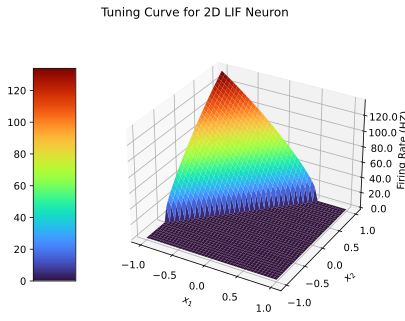

In [41]:
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plt.suptitle("Tuning Curve for 2D LIF Neuron")
plt.xlabel("$x_{1}$")
plt.ylabel("$x_{2}$")
ax.set_zlabel("Firing Rate (HZ)")
#fig.set_figwidth(15)
surf= ax.plot_surface(X = x, Y = y, Z = neuronRate2D, cmap=cm.turbo, linewidth=0, antialiased = False)
fig.colorbar(surf, shrink=0.8, aspect=5, location="left")

ax.zaxis.set_major_formatter('{x:.01f}')

**b) Plotting the 2D tuning curve along the unit circle.** Plot the tuning curve for the same neuron as in a), but only considering the points around the unit circle, i.e., sample the activation for different angles $\theta$. Fit a curve of the form $c_1 \cos(c_2\theta+c_3)+c_4$ to the tuning curve and plot it as well.

Creating helper functions

In [42]:
def cosineGiven(theta, c1, c2, c3, c4):
    return c1* np.cos(c2 * theta + c3) + c4


In [43]:
neuronTwoD.clearRate()

numSamples = 20854
thetaValue = np.linspace(-np.pi, np.pi, numSamples)

for theta in thetaValue:
    neuronTwoD.findRate([np.cos(theta), np.sin(theta)])

thetaRate = neuronTwoD.rate

popt, pcov = sci.curve_fit(cosineGiven, thetaValue, thetaRate)

cosineFit = []

for theta in thetaValue:
    cosineFit.append(cosineGiven(theta, *popt))


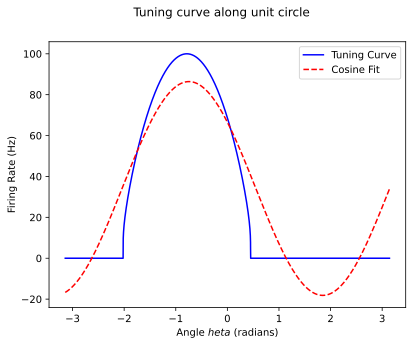

In [44]:
plt.suptitle("Tuning curve along unit circle")
plt.plot(thetaValue, thetaRate, "b", label="Tuning Curve")
plt.plot(thetaValue, cosineFit, "r", linestyle="dashed", label="Cosine Fit")
plt.xlabel("Angle $\theta$ (radians)")
plt.ylabel("Firing Rate (Hz)")
plt.legend()

**c) Discussion.** What makes a cosine a good choice for the curve fit in 2.1b? Why does it differ from the ideal curve?

As can be seen in the figure above, the tuning curve for a 2D LIF neuron seems to fir the given cosine function fairly well. This is simply because of the exponential effects in the LIF 2D neuron that makes the cosine function a good choice to curve fit our LIF-2D firing rate.

However, there are distinctions between the cosine function and the ideal curve. The primary difference lies in the cosine function's continuous nature, which results in it being defined across regions where the tuning curve's value is 0, as indicated in the graph. It's precisely at these points that the cosine function falls short of being the ideal curve!

## 2.2 Vector representation

**a) Choosing encoding vectors.** Generate a set of $100$ random unit vectors uniformly distributed around the unit circle. These will be the encoders $\vec e$ for $100$ neurons. Plot these vectors with a quiver or line plot (i.e., not just points, but lines/arrows to the points).

Helper functions iuf any


Generating the random unit vectors and then plotting them out

In [45]:
numUnitVectors = 100
encoders = []
thetaValues = []

for i in range(numUnitVectors):
    angle = np.random.uniform(0, 2* np.pi)
    unitVector = [np.cos(angle), np.sin(angle)]
    thetaValues.append(angle)
    encoders.append(unitVector)

U,V = zip(*encoders)
xy = np.zeros(len(encoders))


Plotting the quivers out on a unit circle

Text(0, 0.5, '$y$')

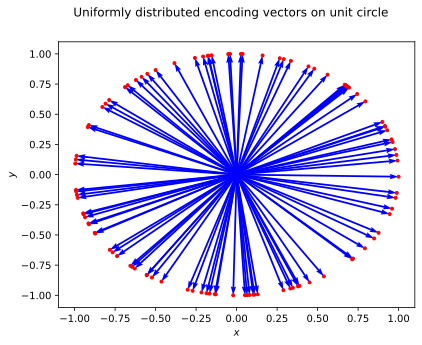

In [46]:
plt.suptitle("Uniformly distributed encoding vectors on unit circle")
ax = plt.gca()
plt.plot(U, V, ".", color="r")
ax.quiver(xy, xy, U, V, angles="xy", scale_units="xy", scale=1, color="b", width=0.005)
domain=[-1.1, 1.1]
ax.set_xlim(domain)
ax.set_ylim(domain)
plt.xlabel("$x$")
plt.ylabel("$y$")

**b) Computing the identity decoder.** Use LIF neurons with the same properties as in question 1.3. When computing the decoders, take into account noise with $\sigma = 0.2\max(A)$. Plot the decoders in the same way you plotted the encoders.

In [47]:
x, y = np.linspace(-1,1,41), np.linspace(-1,1,41)
x, y = np.meshgrid(x,y)


inputs=[]
for i in range(len(x)):
    for j in range(len(x)):
        inputs.append([x[j][i], y[j][i]])

neuronsLIF2D = []
activitiesLIF2D = []

for theta in thetaValues:
    aMaxLIF = np.random.uniform(lowFreq, highFreq)
    angleValue = np.random.uniform(0, 2*np.pi)
    xIntereceptLIF = [np.cos(angleValue), np.sin(angleValue)]
    neuron = LIF2DNeuron(aMaxLIF, xIntereceptLIF, theta, theta)
    neuronsLIF2D.append(neuron)

for neuron in neuronsLIF2D:
    activitiesLIF2D.append(neuron.rate)

for neuron in neuronsLIF2D:
    neuron.findRate2D(inputs)

A_LIF = np.array(activitiesLIF2D)
X_LIF = np.array(inputs)

noiseStdDevLIF = 0.2 * np.amax(A_LIF)

E_Noise = np.random.normal(scale=noiseStdDevLIF, size=np.shape(A_LIF))
A_LIF_Noise = A_LIF + E_Noise

N = len(inputs)
n = len(neuronsLIF2D)
d = np.linalg.lstsq(
    A_LIF @ A_LIF.T + N * np.square(noiseStdDevLIF) * np.eye(n),
    A_LIF @ X_LIF,
    rcond=None,
)[0]

Text(0, 0.5, '$y$')

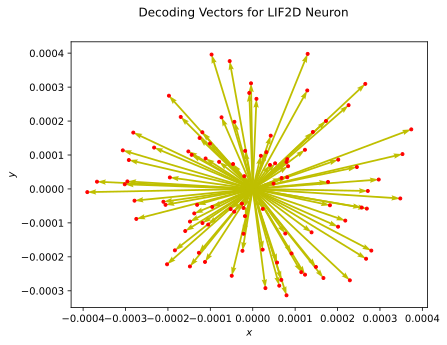

In [48]:
u, v = zip(*d)
XY = np.zeros(len(d))

plt.suptitle("Decoding Vectors for LIF2D Neuron")
ax=plt.gca()
ax.quiver(XY, XY, u, v, angles="xy", scale_units="xy", scale=1, color="y", width=0.005)
plt.plot(u,v,".", color="r", label ="Decoders")

plt.xlabel("$x$")
plt.ylabel("$y$")

**c) Discussion.** How do these decoding vectors compare to the encoding vectors?

If we compare the two fiures, we can see that the encoding vectors have a magnitude approximately equal to 1. In contrast to this, the decoding vectors have a magnitude significantly less to that of the encoding vectors (1/1000th the magnitude).

However, we can also see that the encoding and decoding vectors are almost similar in their distribution. This results in the conclusion that the decoders can maintain some information about direction, but has lost its magnitude

**d) Testing the decoder.** Generate 20 random $\vec x$ values throughout the unit circle (i.e.,~with different directions and radiuses). For each $\vec x$ value, determine the neural activity $a_i$ for each of the 100 neurons. Now decode these values (i.e. compute $\hat{x} = D \vec a$) using the decoders from part b). Plot the original and decoded values on the same graph in different colours, and compute the RMSE.

In [49]:
numRandomVectors = 20

xInputs=[]

for i in range (numRandomVectors):
    angle = np.random.uniform(0, 2* np.pi)
    radius = np.random.uniform(0 , 1)
    point = [radius * np.cos(angle), radius * np.sin(angle)]
    xInputs.append(point)
neuronNoise = neuronsLIF2D

for neuron in neuronNoise:
    neuron.clearRate()

for neuron in neuronNoise:
    neuron.findRate2D(xInputs)

acitivitiesNoise = []

for neuron in neuronNoise:
    acitivitiesNoise.append(neuron.rate)

A = np.array(acitivitiesNoise)
xHat = np.dot(d.T, A)
u,v = zip(*xInputs)
w,m = zip(*xHat.T)
xy = np.zeros(numRandomVectors)


Plotting out the values

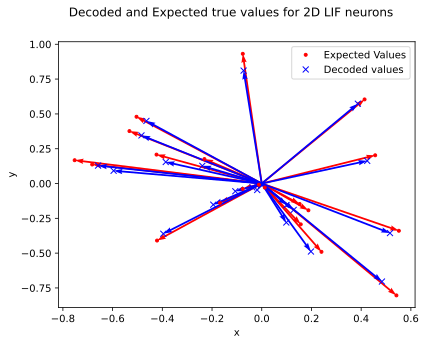

In [50]:
plt.suptitle("Decoded and Expected true values for 2D LIF neurons")
ax = plt.gca()
plt.plot(u,v,".",color ="r", label="Expected Values")
plt.plot(w, m, "x", color="b", label="Decoded values")
ax.quiver(xy, xy, u, v, angles="xy", scale_units="xy", scale=1, color="r", width=0.005)
ax.quiver(xy, xy, w, m, angles="xy", scale_units="xy", scale=1, color="b", width=0.005)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

Onto the next frontier, calculating the RMSE value

In [51]:
def nDimRMSE(x, y):
    difference = x-y
    d = np.power(difference, 2)
    d = d.flatten()
    mu = np.mean(d)
    return np.round(np.sqrt(mu), 10)

#print(nDimRMSE(10,6))


errorRMSE = nDimRMSE(np.array(xInputs), xHat.T)

print("---------------------------------------------")
print("Root Mean Squared Error =", errorRMSE)
print("---------------------------------------------")

---------------------------------------------
Root Mean Squared Error = 0.0461171511
---------------------------------------------


**e) Using encoders as decoders.** Repeat part d) but use the *encoders* as decoders. This is what Georgopoulos used in his original approach to decoding information from populations of neurons. Plot the decoded values and compute the RMSE. In addition, recompute the RMSE in both cases, but ignore the magnitude of the decoded vectors by normalizing before computing the RMSE.

Text(0, 0.5, 'y')

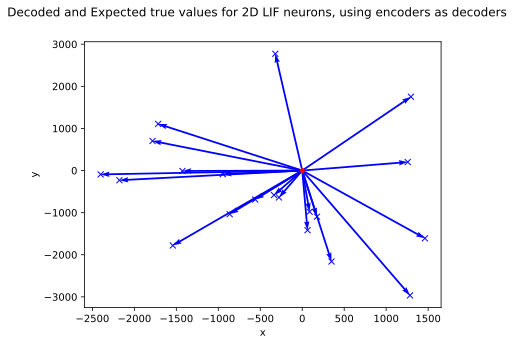

In [52]:
enc2dec = np.array(encoders)
xHatEncoder = np.dot(enc2dec.T, A)

u,v = zip(*xInputs)
w,m = zip(*xHatEncoder.T)
xy = np.zeros(numRandomVectors)

plt.suptitle("Decoded and Expected true values for 2D LIF neurons, using encoders as decoders")
ax=plt.gca()
plt.plot(u,v,".",color ="r", label="Expected Values")
plt.plot(w, m, "x", color="b", label="Decoded values")
ax.quiver(xy, xy, u, v, angles="xy", scale_units="xy", scale=1, color="r", width=0.005)
ax.quiver(xy, xy, w, m, angles="xy", scale_units="xy", scale=1, color="b", width=0.005)
plt.xlabel("x")
plt.ylabel("y")

Calculating RMSE

In [53]:
errorEnc2Dec = nDimRMSE(np.array(xInputs), xHatEncoder.T)
print("---------------------------------------------")
print("Root Mean Squared Error =", errorEnc2Dec)
print("---------------------------------------------")

---------------------------------------------
Root Mean Squared Error = 1310.7600365585
---------------------------------------------


Normalizing values and recomputing the RMSE values

In [54]:
# Normalizing inputs

xUnnorm = np.array(xInputs)
normalizedX= np.linalg.norm(xUnnorm)
xNormalized = xUnnorm / normalizedX

# Normalizing xHat

xHat = xHat.T
normalizedXHat = np.linalg.norm(xHat)
xHatNormalized = xHat / normalizedXHat

# Normalizing xHat Encoders

xHatEncoder = xHatEncoder.T
normalizedXHatEncoder = np.linalg.norm(xHatEncoder)
xHatEncoderNormalized = xHatEncoder / normalizedXHatEncoder

# Calculate and print RMSE
xNormalizedRMSE = nDimRMSE(xNormalized, xHatNormalized)
xNormalizedEncoderRMSE = nDimRMSE(xNormalized, xHatEncoderNormalized)

print("---------------------------------------------")
print("Root Mean Squared Error (Normalized Vectors) =", xNormalizedRMSE)
print("---------------------------------------------")

print("---------------------------------------------")
print("Root Mean Squared Error (Normalized Vectors with Encoders as Decoders) =", xNormalizedEncoderRMSE)
print("---------------------------------------------")


---------------------------------------------
Root Mean Squared Error (Normalized Vectors) = 0.0114865556
---------------------------------------------
---------------------------------------------
Root Mean Squared Error (Normalized Vectors with Encoders as Decoders) = 0.0509548326
---------------------------------------------


**f) Discussion.** When computing the RMSE on the normalized vectors, using the encoders as decoders should result in a larger, yet still surprisingly small error. Thinking about random unit vectors in high dimensional spaces, why is this the case? What are the relative merits of these two approaches to decoding?

In high dimensional spaces (with random vectors generated), as can be seen in the results above, that the RMSE for using encoders as decoders results in a larger error (as compared to the normalized vectors), but still is of the same small magnitude. This goes to show that using encoders to decoders might help alot when it comes to computational efficiency, as we can skip the least-squares calculation of determining the optimal decoders (which is computationally intensive ).


This fact would be awesome when it comes to larger populations of neurons as this would result in a larger computational overhead that can be avodied with a low error.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

$$ END OF ASSIGNMENT $$

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------